In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
import scipy . stats as scs
import arch
from pandas import *
# import pandas_datareader.data as web
import matplotlib.dates as mdates
import numpy.random as npr
%matplotlib inline
%load_ext autoreload
%autoreload 2

/opt/anaconda/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# Functions

In [2]:
def plot_long_time_series(x, y):
    
    years = mdates.YearLocator()   # every year
    months = mdates.MonthLocator()  # every month
    yearsFmt = mdates.DateFormatter('%Y')
    
    fig, ax = plt.subplots()
    ax.plot(x.astype(np.datetime64), y)

    # format the ticks
    ax.xaxis.set_major_locator(years)
    ax.xaxis.set_major_formatter(yearsFmt)
    ax.xaxis.set_minor_locator(months)
    ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
    ax.grid(True)

    # rotates and right aligns the x labels, and moves the bottom of the
    # axes up to make room for them
    fig.autofmt_xdate()

    plt.show()

In [3]:
def compute_var(x, alpha):
    return -np.percentile(x, alpha*100)

In [4]:
def compute_es(x, alpha):
    var_alpha = -compute_var(x, alpha)
    prcentile = sum(x<=var_alpha)/float(len(x))
    y = x * (x <= var_alpha)
    return -1.0/alpha*(y.mean()+var_alpha*(alpha-prcentile))

In [5]:
def gen_paths (S0 ,r,sigma , T,M,I):
    dt= float (T)/M
    paths = np.zeros ((M+1,I))
    paths[0] = S0
    for t in range (1,M +1):
        rand = np.random.randn (I)
        paths[t] = paths[t-1] * np.exp((r-0.5* sigma**2) * dt+ sigma * np.sqrt(dt)*rand)
    return paths

In [6]:
def make_path(R, S0=1, b_return_path=True):
    # R.shape = [T, N]
    R_with_0 = np.zeros((R.shape[0]+1,R.shape[1]))
    R_with_0[1:,:] = R
    cumulative_returns = R_with_0.cumsum(axis=0)
    if b_return_path:
        return np.exp(cumulative_returns)*S0
    else:
        return cumulative_returns

# Data

### Task 1: Data Download

Download the following equity prices from "iex": Google [GOOG], Microsoft [MSFT], Facebook [FB], S&P 500 [SPY] from 2016.01.01

Plot the prices!

#### Solution

In [7]:
# df = pd.DataFrame()
list_tickers = ['MSFT', 'GOOG', 'FB', 'SPY']
# for ticker in list_tickers:
#     stock_data = web.DataReader(name =ticker, data_source ='iex', start ='2016-01-01')
#     df[ticker] = stock_data.close

In [8]:
# if the previous step does not work read from csv:
df = pd.read_csv('returns.csv', index_col='date')

In [9]:
df.tail()

MSFT     GOOG      FB     SPY
date                                      
2018-03-23  87.18  1021.57  159.39  258.05
2018-03-26  93.78  1053.21  160.06  265.11
2018-03-27  89.47  1005.10  152.22  260.60
2018-03-28  89.39  1004.56  153.03  259.83
2018-03-29  91.27  1031.79  159.79  263.15

MSFT


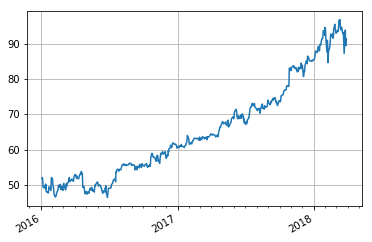

GOOG


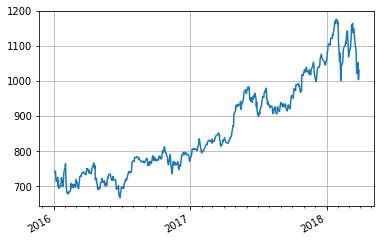

FB


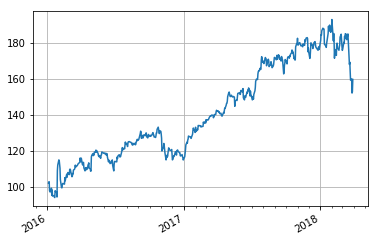

SPY


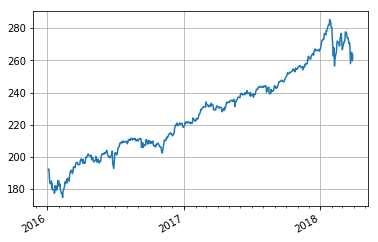

In [10]:
list_tickers = ['MSFT', 'GOOG', 'FB', 'SPY']
for ticker in list_tickers:
    print(ticker)
    plot_long_time_series(df.index, df[ticker])
    

### Task 2: Calculate Returns

Calculate the daily log-returns and arithmetic returns for each equity, and write out the descriptive statistics of the log_Returns

#### Solution

In [11]:

for ticker in list_tickers:
    df[ticker + '_ret'] = df[ticker].pct_change()
    df[ticker + '_log_ret'] = np.log(df[ticker]) - np.log(df[ticker].shift(1))
df = df.iloc[1:]

In [12]:
df.tail()

MSFT     GOOG      FB     SPY  MSFT_ret  MSFT_log_ret  GOOG_ret  \
date                                                                           
2018-03-23  87.18  1021.57  159.39  258.05 -0.029068     -0.029499 -0.026223   
2018-03-26  93.78  1053.21  160.06  265.11  0.075705      0.072977  0.030972   
2018-03-27  89.47  1005.10  152.22  260.60 -0.045959     -0.047048 -0.045679   
2018-03-28  89.39  1004.56  153.03  259.83 -0.000894     -0.000895 -0.000537   
2018-03-29  91.27  1031.79  159.79  263.15  0.021031      0.020813  0.027106   

            GOOG_log_ret    FB_ret  FB_log_ret   SPY_ret  SPY_log_ret  
date                                                                   
2018-03-23     -0.026573 -0.033356   -0.033925 -0.021315    -0.021545  
2018-03-26      0.030502  0.004204    0.004195  0.027359     0.026991  
2018-03-27     -0.046756 -0.048982   -0.050222 -0.017012    -0.017158  
2018-03-28     -0.000537  0.005321    0.005307 -0.002955    -0.002959  
2018-03-29      0.026746  0.044174    0.043226  0.012778     0.012697

In [13]:
for ticker in list_tickers:
    print("XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX")
    print(df[ticker + '_log_ret'].describe())

XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
count    563.000000
mean       0.001002
std        0.013167
min       -0.074412
25%       -0.004584
50%        0.000715
75%        0.007052
max        0.072977
Name: MSFT_log_ret, dtype: float64
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
count    563.000000
mean       0.000586
std        0.012493
min       -0.054645
25%       -0.004217
50%        0.000933
75%        0.007634
max        0.046910
Name: GOOG_log_ret, dtype: float64
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
count    563.000000
mean       0.000793
std        0.015590
min       -0.070097
25%       -0.005222
50%        0.001051
75%        0.008620
max        0.144286
Name: FB_log_ret, dtype: float64
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
count    563.000000
mean       0.000557
std        0.007436
min       -0.042722
25%       -0.001967
50%        0.000517
75%        0.003963
max        0.026991
Name: SPY_log_ret, dtype: float64


# VaR and Expected Shortfall

## Parametric VaR, ES

### Task 1: Calculate VaR and ES

a) Calculate 1 day VaR and ES with p = 95%, 99% for S&P 500!

b) How would you calculate 10 days VaR and ES?

#### Solution

In [14]:
# a)
sp_returns = df['SPY_log_ret']
mu = sp_returns.mean()
sigma = sp_returns.std()
print('Assumption: r~N({0},{1})'.format(mu, sigma*sigma))

list_alpha = [0.05, 0.01]
for alpha in list_alpha:
    print('###############################################')
    var = -scs.norm.ppf(alpha , loc=mu ,scale=sigma)
    es = scs.norm.pdf(scs.norm.ppf(alpha))*1/alpha*sigma-mu
    print('VaR_{}: {}'.format(alpha, var))
    print('ES_{}: {}'.format(alpha, es))


Assumption: r~N(0.000557317031042,5.52954145116e-05)
###############################################
VaR_0.05: 0.0116739603664
ES_0.05: 0.0147811982791
###############################################
VaR_0.01: 0.0167416120069
ES_0.01: 0.0192614522008


In [15]:
# b)
sp_returns = df['SPY_log_ret']
days = 10.0
mu_10 = sp_returns.mean() * days
sigma_10 = sp_returns.std() * np.sqrt(days)
print('Assumption: r~N({0},{1})'.format(mu_10, sigma_10*sigma_10))

list_alpha = [0.05, 0.01]
for alpha in list_alpha:
    print('###############################################')
    var = -scs.norm.ppf(alpha , loc=mu_10 ,scale=sigma_10)
    es = scs.norm.pdf(scs.norm.ppf(alpha))*1/alpha*sigma_10-mu_10
    print('VaR_{}: {}'.format(alpha, var))
    print('ES_{}: {}'.format(alpha, es))

Assumption: r~N(0.00557317031042,0.000552954145116)
###############################################
VaR_0.05: 0.0331055249589
ES_0.05: 0.0429314739949
###############################################
VaR_0.01: 0.049130846531
ES_0.01: 0.0570992808834


### Task 2: Normality assumption (Benchmark Data)

Check the normality assumptions of the log-returns for the generated path (use the gen path function S0=100, r=0.05, sigma=0.2, T=1.0, M=50, I=10000):

a) Generate normal distributed 

b) Plot the histogram of the log-returns

c) Generate QQ Plot

d) Normality Test

#### Solution

In [16]:
# a)
paths=gen_paths (100, 0.05, 0.2, 1.0, 50, 10000)
log_returns=np.log(paths [1:]/ paths [0: -1])

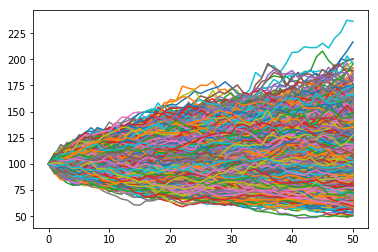

In [18]:
plt.plot(paths)
plt.show()

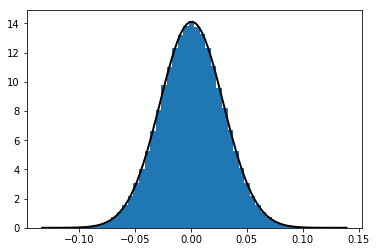

In [29]:
# b)

plt.hist(log_returns.flatten(), bins=50, density=True) # instead of density you might need to use normed=True
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = scs.norm.pdf(x, np.mean(log_returns.flatten()), np.std(log_returns.flatten()))
plt.plot(x, p, 'k', linewidth=2)

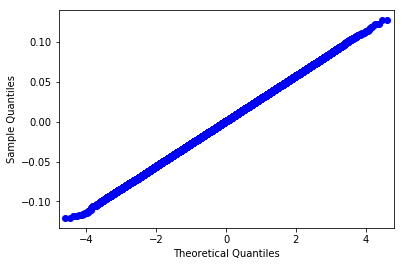

In [18]:
# c)
sm.qqplot(log_returns.flatten())
print('')

In [19]:
# d)

print(scs.skew(log_returns.flatten ()))
print(scs.skewtest(log_returns.flatten ()))

print(scs.kurtosis(log_returns.flatten ()))
print(scs.kurtosistest(log_returns.flatten ()))
scs.normaltest(log_returns.flatten ())

0.00166800647762
SkewtestResult(statistic=0.4815188819405251, pvalue=0.6301477631810948)
0.000968978429406
KurtosistestResult(statistic=0.14499116067120008, pvalue=0.8847178508047693)


NormaltestResult(statistic=0.25288287033803514, pvalue=0.8812257568698221)

### Task 3: Normality assumption (Market Data)

Check the normality assumptions of the log-returns for SPY:

a) Plot the histogram of the log-returns

b) Generate QQ Plot

c) Normality Test
    

#### Solution

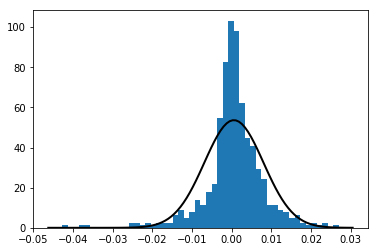

In [30]:
# a)
sp_returns = df['SPY_log_ret']
plt.hist(sp_returns, bins=50, density=True)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = scs.norm.pdf(x, mu, sigma)
plt.plot(x, p, 'k', linewidth=2)


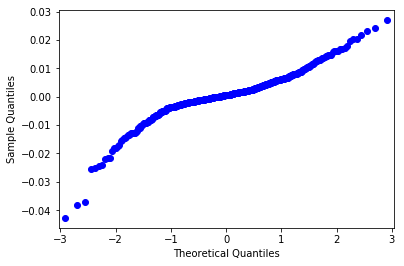

In [21]:
# b) QQ-Plot
sm.qqplot(sp_returns)
print("")

In [22]:
# c)
print(scs.skew(sp_returns))
print(scs.skewtest(sp_returns))

print(scs.kurtosis(sp_returns))
print(scs.kurtosistest(sp_returns))
scs.normaltest(sp_returns)

-0.943268847836
SkewtestResult(statistic=-7.943466692976218, pvalue=1.9660750519969595e-15)
5.54015999378
KurtosistestResult(statistic=8.673284038588672, pvalue=4.198329799962909e-18)


NormaltestResult(statistic=138.32451911645956, pvalue=9.187816607134067e-31)

## Monte Carlo Simulation

### Task 1: Generate path with Normal distribution

a) Generate a 10 days path with normal distribution for SPY. Plot the path. (10000 simulation)

b) Calculate 1 day and 10 days VaR and ES with p = 95%, 99% for S&P 500! 

c) Compare the results with the parametric VaR and ES respectively!


#### Solution

In [31]:
# a)
sp_returns = df['SPY_log_ret']
mu = sp_returns.mean()
sigma = sp_returns.std()
R = npr.normal(loc=mu, scale=sigma, size=(10, 10000))

In [32]:
R.shape

(10, 10000)

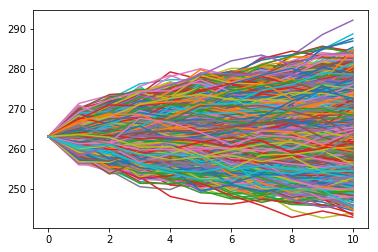

In [33]:
paths = make_path(R, S0=df['SPY'].iloc[-1])
plt.plot(paths)
plt.show()

In [34]:
# b)
log_returns= make_path(R, b_return_path=False)
# path
# One day var:
list_alpha = [0.05, 0.01]
for alpha in list_alpha:
    print('###############################################')
    var = compute_var(log_returns[1,:], alpha)
    es = compute_es(log_returns[1,:], alpha)
    print('VaR_{}: {}'.format(alpha, var))
    print('ES_{}: {}'.format(alpha, es))

###############################################
VaR_0.05: 0.0120192110088
ES_0.05: 0.0149533169454
###############################################
VaR_0.01: 0.0167115638575
ES_0.01: 0.0192925765728


### Task 2: Generate path with Student-T distribution

a) Generate a 10 days path with student-T distribution (dof=3)for SPY. Plot the path. (10000 simulation)

b) Calculate 1 day and 10 days VaR and ES with p = 95%, 99% for S&P 500! 

c) Compare the results with the Normal Distribution VaR and ES!


#### Solution

In [45]:
# a)
sp_returns = df['SPY_log_ret']
mu = sp_returns.mean()
sigma = sp_returns.std()
R = npr.standard_t(3, (10, 10000))

print(np.mean(R))
print(np.std(R))
# First we need to standardize R:
R = (R-np.mean(R))/np.std(R) 
print(np.mean(R))
print(np.std(R))
# We can scale it back to the estimated parameters
R = R*sigma+mu
print(np.mean(R))
print(np.std(R))

0.01111867924872923
1.7285103825647068
-8.526512829121201e-18
0.9999999999999999
0.0005573170310419691
0.007436088656788438


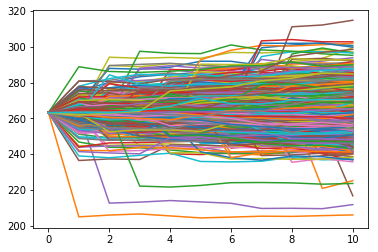

In [46]:
paths = make_path(R, S0=df['SPY'].iloc[-1])
plt.plot(paths)
plt.show()

In [47]:
# b)
log_returns= make_path(R, b_return_path=False)
# path
# One day var:
list_alpha = [0.05, 0.01]
for alpha in list_alpha:
    print('###############################################')
    var = compute_var(log_returns[1,:], alpha)
    es = compute_es(log_returns[1,:], alpha)
    print('VaR_{}: {}'.format(alpha, var))
    print('ES_{}: {}'.format(alpha, es))

###############################################
VaR_0.05: 0.00988922280966
ES_0.05: 0.0177495576737
###############################################
VaR_0.01: 0.0203517364523
ES_0.01: 0.0351588586569


### Task 3: Calculate VaR using Antithethic variables

Calculate 1 day VaR and ES with alpha = 95%, 99% for S&P 500! Use Antithetic variables

#### Solution

In [48]:
sp_returns = df['SPY_log_ret']
mu = sp_returns.mean()
sigma = sp_returns.std()
R = npr.randn(10000)

In [49]:
list_alpha = [0.05, 0.01]
for alpha in list_alpha:
    print('###############################################')
    var = compute_var(log_returns[1,:], alpha)
    [pct_up , pct_down] = np.percentile(R , [alpha*100, 100.0-alpha*100.0])
    var = -(sigma*( pct_up  - pct_down )/2+mu)
    print('VaR_{}: {}'.format(alpha, var))


###############################################
VaR_0.05: 0.0117037603986
###############################################
VaR_0.01: 0.0166338001804


### Task 4: Calculate VaR using GARCH(1,1)

a) Estimate GARCH(1,1) model for this excercise!

b) Calculate 1 day VaR and ES with alpha = 95%, 99% for Facebook! 

c) Calculate 50 days VaR and ES with alpha = 95%, 99% for Facebook!

#### Solution

In [50]:
# a)
fb_returns = df['FB_log_ret']
am = arch.arch_model(fb_returns)
res = am.fit()

Iteration:      1,   Func. Count:      6,   Neg. LLF: -1605.52942333
Iteration:      2,   Func. Count:     19,   Neg. LLF: -1605.73916127
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -1605.7391649624076
            Iterations: 2
            Function evaluations: 30
            Gradient evaluations: 2


In [51]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:             FB_log_ret   R-squared:                      -0.001
Mean Model:             Constant Mean   Adj. R-squared:                 -0.001
Vol Model:                      GARCH   Log-Likelihood:                1605.74
Distribution:                  Normal   AIC:                          -3203.48
Method:            Maximum Likelihood   BIC:                          -3186.15
                                        No. Observations:                  563
Date:                Fri, Apr 06 2018   Df Residuals:                      559
Time:                        15:28:53   Df Model:                            4
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu         1.1439e-03  3.900e-05     29.330 4.268e-189 [1.067e-03,1.220e-03]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      4.8533e-06  2.121e-11  2.289e+05      0.000 [4.853e-06,4.853e-06]
alpha[1]       0.0500  3.479e-02      1.437      0.151  [-1.818e-02,  0.118]
beta[1]        0.9300  2.470e-02     37.658 2.432e-310     [  0.882,  0.978]
============================================================================

Covariance estimator: robust
"""

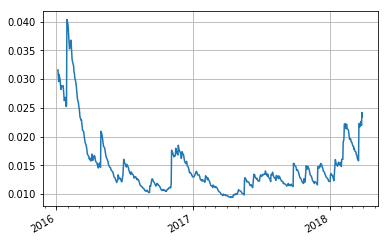

In [52]:
plot_long_time_series(df.index, res.conditional_volatility)

In [55]:
# b) 
fcast = res.forecast(method="simulation",simulations =1000, horizon=50)
R = fcast.simulations.values[-1,:,:].T
log_returns= make_path(R, b_return_path=False)
# path
# One day var:
list_alpha = [0.05, 0.01]
for alpha in list_alpha:
    print('###############################################')
    var = compute_var(log_returns[1,:], alpha)
    es = compute_es(log_returns[1,:], alpha)
    print('VaR_{}: {}'.format(alpha, var))
    print('ES_{}: {}'.format(alpha, es))

###############################################
VaR_0.05: 0.0394873812579
ES_0.05: 0.0491255575246
###############################################
VaR_0.01: 0.0559038269675
ES_0.01: 0.0647069658967


In [56]:
# c)
# 50 days var:
list_alpha = [0.05, 0.01]
for alpha in list_alpha:
    print('###############################################')
    var = compute_var(log_returns[50,:], alpha)
    es = compute_es(log_returns[50,:], alpha)
    print('VaR_{}: {}'.format(alpha, var))
    print('ES_{}: {}'.format(alpha, es))

###############################################
VaR_0.05: 0.186519040649
ES_0.05: 0.265277510681
###############################################
VaR_0.01: 0.308739543901
ES_0.01: 0.371858277268


## Historical VaR and Bootstrap Simulation

### Task 1: Calculate historical VaR and ES for SPY

a) Calculate 1 day and 10 days VaR and ES with alpha 1%!

b) Backtest the results with the BIS Traffic Light System!

#### Solution

In [59]:
# a)
sp_returns = df['SPY_log_ret']
alpha = 0.01
var = compute_var(sp_returns, alpha)
es = compute_es(sp_returns, alpha)
print('VaR_{}: {}'.format(alpha, var))
print('ES_{}: {}'.format(alpha, es))

VaR_0.01: 0.0242479510556
ES_0.01: 0.0326734762752


In [60]:
# b)
backtest_returns = sp_returns[-251:-1]
breach_value = sum(-backtest_returns>var)

if breach_value < 5:
    result = 'Green'
elif breach_value < 10:
    result = 'Yellow'
else:
    result = 'Red'
print('Number of VaR breaching: {0}\nVaR model performance: {1}'.format(breach_value, result))

Number of VaR breaching: 3
VaR model performance: Green


### Task 2: Bootstrap Method for portfolio VaR calculation


You have a portfolio which consists \$1000 MSFT, \$500 GOOG and \$750 FB.

a) Estimate the 99% one day VaR and ES using Bootstrap Method!

b) Backtest your results with BIS Traffic Light System!

#### Solution

In [61]:
# a)
N = 10000
df2 = df[['GOOG_log_ret', 'MSFT_log_ret', 'FB_log_ret']].reset_index()
nr_of_rets = len(df2)
return_indexes = npr.choice(range(nr_of_rets), N)

In [62]:
portfolio_pv = 2250.0
portfolio_rets = np.zeros(N)
for i in range(N):
    portfolio_rets[i] = np.log(
        (
        1000*np.exp(df2.loc[return_indexes[i], 'MSFT_log_ret'])+
        500*np.exp(df2.loc[return_indexes[i], 'GOOG_log_ret'])+
        750*np.exp(df2.loc[return_indexes[i], 'FB_log_ret'])
        )/portfolio_pv
    )


In [63]:
alpha = 0.01
var = compute_var(portfolio_rets, alpha)
es = compute_es(portfolio_rets, alpha)
print('VaR_{}: {}'.format(alpha, var))
print('ES_{}: {}'.format(alpha, es))

VaR_0.01: 0.0383518636726
ES_0.01: 0.0474942966552


In [64]:
# b)
backtest_returns = np.zeros(250)
return_indexes = df2.index[-251:-1]
for i in range(250):
    backtest_returns[i] = np.log(
        (
        1000*np.exp(df2.loc[return_indexes[i], 'MSFT_log_ret'])+
        500*np.exp(df2.loc[return_indexes[i], 'GOOG_log_ret'])+
        750*np.exp(df2.loc[return_indexes[i], 'FB_log_ret'])
        )/portfolio_pv
    )

breach_value = sum(-backtest_returns>var)

if breach_value < 5:
    result = 'Green'
elif breach_value < 10:
    result = 'Yellow'
else:
    result = 'Red'
print('Number of VaR breaching: {0}\nVaR model performance: {1}'.format(breach_value, result))

Number of VaR breaching: 3
VaR model performance: Green


In [65]:
df2.loc[return_indexes]

date  GOOG_log_ret  MSFT_log_ret  FB_log_ret
312  2017-03-31     -0.002336      0.002280   -0.002531
313  2017-04-03      0.010779     -0.004717    0.001618
314  2017-04-04     -0.004758      0.002742   -0.003873
315  2017-04-05     -0.003794     -0.002589    0.000846
316  2017-04-06     -0.004255      0.002589   -0.004805
317  2017-04-07     -0.003885     -0.000761   -0.002766
318  2017-04-10      0.000073     -0.002286    0.001845
319  2017-04-11     -0.001675     -0.000764   -0.007973
320  2017-04-12      0.001177     -0.003826   -0.002433
321  2017-04-13     -0.000922     -0.004301   -0.001362
322  2017-04-17      0.016391      0.008127    0.014458
323  2017-04-18     -0.000418     -0.001376   -0.003258
324  2017-04-19      0.001660     -0.005367    0.009250
325  2017-04-20      0.004096      0.007048    0.010697
326  2017-04-21      0.001828      0.013646   -0.000835
327  2017-04-24      0.022944      0.016876    0.012381
328  2017-04-25      0.010997      0.005759    0.006987
329  2017-04-26     -0.000654     -0.001327    0.000478
330  2017-04-27      0.002887      0.006466    0.007748
331  2017-04-28      0.035629      0.002779    0.017117
332  2017-05-01      0.007270      0.013781    0.014602
333  2017-05-02      0.004232     -0.001587    0.002097
334  2017-05-03      0.011500     -0.003178   -0.006435
335  2017-05-04      0.004971     -0.003917   -0.006278
336  2017-05-05     -0.004874      0.002757   -0.004052
337  2017-05-08      0.007704     -0.000870    0.005443
338  2017-05-09     -0.002282      0.001450   -0.003847
339  2017-05-10     -0.003643      0.003902   -0.001263
340  2017-05-11      0.001958     -0.012339   -0.001665
341  2017-05-12      0.001739     -0.001170    0.001931
..          ...           ...           ...         ...
532  2018-02-14      0.016590      0.015537    0.036128
533  2018-02-15      0.018359      0.020167    0.002448
534  2018-02-16      0.004834     -0.007148   -0.014553
535  2018-02-20      0.006972      0.007796   -0.007641
536  2018-02-21      0.008022     -0.013355    0.010737
537  2018-02-22     -0.004247      0.002620    0.006052
538  2018-02-23      0.018054      0.025083    0.023740
539  2018-02-26      0.014939      0.014355    0.008908
540  2018-02-27     -0.022512     -0.012868   -0.018942
541  2018-02-28     -0.012200     -0.004575   -0.017456
542  2018-03-01     -0.032391     -0.009860   -0.013437
543  2018-03-02      0.008751      0.002152    0.003858
544  2018-03-05      0.011070      0.006321    0.021176
545  2018-03-06      0.003779     -0.003423   -0.003443
546  2018-03-07      0.013226      0.005770    0.021625
547  2018-03-08      0.014636      0.006055   -0.007485
548  2018-03-09      0.029783      0.022099    0.015725
549  2018-03-12      0.003837      0.002380   -0.002541
550  2018-03-13     -0.022870     -0.024690   -0.015711
551  2018-03-14      0.009897     -0.005949    0.012621
552  2018-03-15      0.000078      0.003510   -0.001793
553  2018-03-16     -0.012121      0.004450    0.006668
554  2018-03-19     -0.032129     -0.018241   -0.070097
555  2018-03-20     -0.001920      0.002580   -0.025889
556  2018-03-21     -0.006241     -0.007004    0.007347
557  2018-03-22     -0.039071     -0.029519   -0.026925
558  2018-03-23     -0.026573     -0.029499   -0.033925
559  2018-03-26      0.030502      0.072977    0.004195
560  2018-03-27     -0.046756     -0.047048   -0.050222
561  2018-03-28     -0.000537     -0.000895    0.005307

[250 rows x 4 columns]